In [321]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings

sns.set()
rcParams['figure.figsize'] = (20,10)
pd.options.display.max_columns = None
pd.options.display.max_rows = 200
warnings.filterwarnings('ignore')

from feature_names import *
from utils import *

In [322]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder
from fastai.tabular.core import df_shrink

In [323]:
df_train_temp = pd.read_csv('../Data/competition/train_data_shrink.csv', parse_dates=[startdate])
df_test_temp = pd.read_csv('../Data/competition/test_data_shrink.csv', parse_dates=[startdate])

In [324]:
df_train = df_train_temp.copy()
df_test = df_test_temp.copy()
dfs = [df_train, df_test]

In [325]:
# df_train_temp = pd.read_csv('../Data/competition/train_data.csv')
# df_test_temp = pd.read_csv('../Data/competition/test_data.csv')

# df_train_shrink = df_shrink(df_train_temp)
# df_test_shrink = df_shrink(df_test_temp)

# # save to csv but keep the index
# df_train_shrink.to_csv('../Data/competition/train_data_shrink.csv')
# df_test_shrink.to_csv('../Data/competition/test_data_shrink.csv')
# df_train_shrink.memory_usage(deep=True).sum() / 1024**2

In [326]:
for df in dfs:
  df.columns = df.columns.str.replace('-','_')

In [327]:
df_info_obj = df_info(df_train)
null_contained_cols = df_info_obj[df_info_obj['nan_count']>0].index
df_info_obj.loc[null_contained_cols]

,nan_count,nan_percent,unique_count,dtype
nmme0_tmp2m_34w__ccsm30,15934,4.2408,3840,float64
nmme_tmp2m_56w__ccsm3,10280,2.7360,5000,float64
nmme_prate_34w__ccsm3,8738,2.3256,10139,float64
nmme0_prate_56w__ccsm30,15934,4.2408,5716,float64
nmme0_prate_34w__ccsm30,15934,4.2408,5712,float64
nmme_prate_56w__ccsm3,10280,2.7360,10008,float64
nmme_tmp2m_34w__ccsm3,8738,2.3256,4810,float64
ccsm30,15934,4.2408,3833,float64


In [328]:
for df in dfs:
  df[year] = df[startdate].dt.year
  df[month] = df[startdate].dt.month
  df['week'] = df[startdate].dt.week
  df['day'] = df[startdate].dt.day

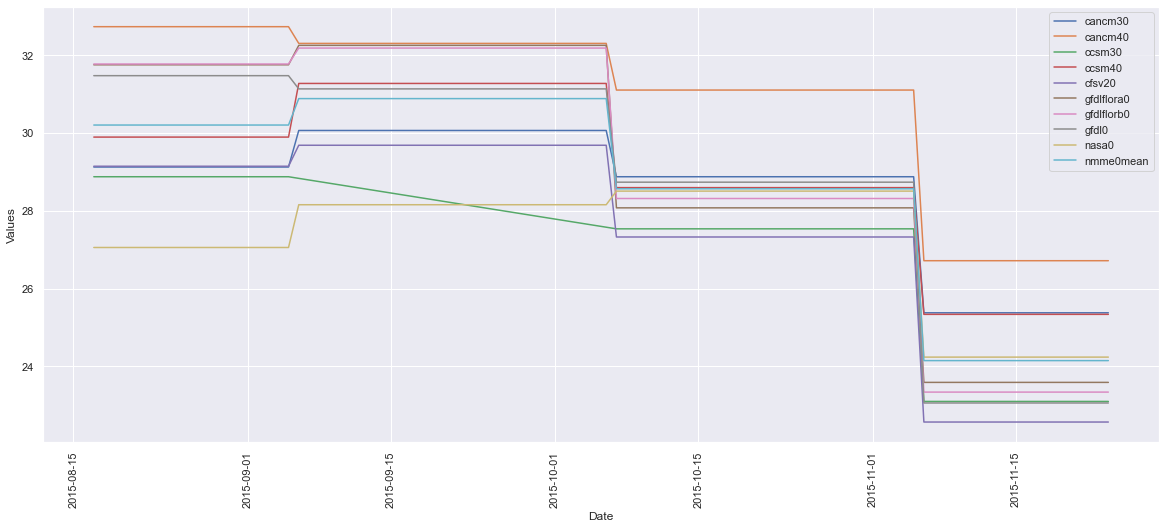

In [329]:
plot_line(
  df=df_train,
  column_name=[
    cancm30,
    cancm40,
    ccsm30,
    ccsm40,
    cfsv20,
    gfdlflora0,
    gfdlflorb0,
    gfdl0,
    nasa0,
    nmme0mean,
  ],
  start_index=350,
  end_index=450
)

In [330]:
# fill some missing values of one type model predict with mean of all models
df_train[nmme0_tmp2m_34w__ccsm30] = df_train[nmme0_tmp2m_34w__ccsm30].fillna(df_train[nmme0_tmp2m_34w__nmme0mean])
df_train[nmme0_prate_34w__ccsm30] = df_train[nmme0_prate_34w__ccsm30].fillna(df_train[nmme0_prate_34w__nmme0mean])
df_train[nmme0_prate_56w__ccsm30] = df_train[nmme0_prate_56w__ccsm30].fillna(df_train[nmme0_prate_56w__nmme0mean])
df_train[nmme_tmp2m_34w__ccsm3] = df_train[nmme_tmp2m_34w__ccsm3].fillna(df_train[nmme_tmp2m_34w__nmmemean])
df_train[nmme_tmp2m_56w__ccsm3] = df_train[nmme_tmp2m_56w__ccsm3].fillna(df_train[nmme_tmp2m_56w__nmmemean])
df_train[nmme_prate_34w__ccsm3] = df_train[nmme_prate_34w__ccsm3].fillna(df_train[nmme_prate_34w__nmmemean])
df_train[nmme_prate_56w__ccsm3] = df_train[nmme_prate_56w__ccsm3].fillna(df_train[nmme_prate_56w__nmmemean])
df_train[ccsm30] = df_train[ccsm30].fillna(df_train[nmme0mean])

In [331]:
# categorical features  
cat_cols = [
  mjo1d__phase,                      # match
  month,                             # match
  climateregions__climateregion,     # match
  day,                               # match
  elevation__elevation,              # match
  
  year,                              # ==> drop
  mei__meirank,                      # ==> only match at value 37 but for small portion ==> drop            
  mei__nip,                          # ==> only match at value 3 ==> create is_mei__nip_3
  mei__mei,                          # ==> drop
  lat,                               # ==> match but need to be rounded
  lon,                               # ==> match but need to be rounded
]

match_cols = [
  mjo1d__phase,
  month,
  climateregions__climateregion,
  elevation__elevation,
  day,
  lat,
  lon,
]

### Handle categorical features

In [332]:
def check_match(df_train, df_test, col):
  return set(df_test[col].value_counts().index).issubset(set(df_train[col].value_counts().index))

for col in cat_cols:
  print(col, check_match(df_train, df_test, col))

mjo1d__phase True
month True
climateregions__climateregion True
day True
elevation__elevation True
year False
mei__meirank False
mei__nip False
mei__mei False
lat True
lon True


In [333]:
# handle unmatched lat, lon
for df in dfs:
  for kind in [lat,lon]:
    df[kind] = df[kind].round(4)

In [334]:
for df in dfs:
  df['is_mei__nip_3'] = (df[mei__nip]==3).astype(int)
  df[location] = (df[lat].astype(str) + '_' + df[lon].astype(str))

In [335]:
# # plot cancm30 grouped by month
# group_cols_1 = [location, month]
# group_name_1 = '_'.join(group_cols_1)

# cols1 = [
#   nmme0_tmp2m_34w__cancm30,
#   nmme0_tmp2m_34w__cancm40,
#   nmme0_tmp2m_34w__ccsm30,
#   nmme0_tmp2m_34w__ccsm40,
#   nmme0_tmp2m_34w__cfsv20,
#   nmme0_tmp2m_34w__gfdlflora0,
#   nmme0_tmp2m_34w__gfdlflorb0,
#   nmme0_tmp2m_34w__gfdl0,
#   nmme0_tmp2m_34w__nasa0,
#   nmme0_tmp2m_34w__nmme0mean,
# ] # ==> max, std
# for col in cols1:
#   for df in dfs:
#     df[f'{group_name_1}_{col}_max'] = df.groupby(group_cols_1)[col].transform('max')
#     df[f'{group_name_1}_{col}_std'] = df.groupby(group_cols_1)[col].transform('std')

# cols2 = [
#   nmme_tmp2m_34w__cancm3,
#   nmme_tmp2m_34w__ccsm3,
#   nmme_tmp2m_34w__ccsm4,
#   nmme_tmp2m_34w__cfsv2,
#   nmme_tmp2m_34w__gfdl,
#   nmme_tmp2m_34w__gfdlflora,
#   nmme_tmp2m_34w__gfdlflorb,
#   nmme_tmp2m_34w__nasa,
#   nmme_tmp2m_34w__nmmemean,
  
#   nmme_tmp2m_56w__cancm4,
#   nmme_tmp2m_56w__ccsm4,
#   nmme_tmp2m_56w__cfsv2,
#   nmme_tmp2m_56w__gfdl,
#   nmme_tmp2m_56w__gfdlflora,
#   nmme_tmp2m_56w__gfdlflorb,
#   nmme_tmp2m_56w__nasa,
#   nmme_tmp2m_56w__nmmemean,
# ]    # => max, min, mean, median

# for col in cols2:
#   for df in dfs:
#     df[f'{group_name_1}_{col}_max'] = df.groupby(group_cols_1)[col].transform('max')
#     df[f'{group_name_1}_{col}_min'] = df.groupby(group_cols_1)[col].transform('min')
#     df[f'{group_name_1}_{col}_mean'] = df.groupby(group_cols_1)[col].transform('mean')
#     df[f'{group_name_1}_{col}_median'] = df.groupby(group_cols_1)[col].transform('median')

# cols3 = [
#   cancm30,
#   cancm40,
#   cfsv20,
#   gfdlflora0,
#   gfdlflorb0,
#   gfdl0,
#   nasa0,
#   nmme0mean,
# ] # => only std
# for col in cols3:
#   for df in dfs:
#     df[f'{group_name_1}_{col}_std'] = df.groupby(group_cols_1)[col].transform('std')

# cols4 = [
#   contest_wind_vwnd_250_14d__wind_vwnd_250, 
#   contest_wind_vwnd_925_14d__wind_vwnd_925, 
#   contest_wind_uwnd_250_14d__wind_uwnd_250, 
#   contest_wind_uwnd_925_14d__wind_uwnd_925, 
#   contest_wind_h100_14d__wind_hgt_100, 
#   contest_wind_h500_14d__wind_hgt_500, 
#   contest_slp_14d__slp, 
#   contest_pevpr_sfc_gauss_14d__pevpr, 
#   contest_pres_sfc_gauss_14d__pres, 
#   contest_precip_14d__precip, 
#   contest_prwtr_eatm_14d__prwtr, 
# ] # => max, skew, median, mean

# for col in cols4:
#   for df in dfs:
#     df[f'{group_name_1}_{col}_max'] = df.groupby(group_cols_1)[col].transform('max')
#     df[f'{group_name_1}_{col}_skew'] = df.groupby(group_cols_1)[col].transform('skew')
#     df[f'{group_name_1}_{col}_median'] = df.groupby(group_cols_1)[col].transform('median')
#     df[f'{group_name_1}_{col}_mean'] = df.groupby(group_cols_1)[col].transform('mean')
# for col in [*cols1, *cols2, *cols3, *cols4]:
#   for df in dfs:
#     for shift in [-1,1]:
#       df[f'location_week_{col}_lag_{shift}'] = df.groupby([location, week])[col].shift(shift)

In [336]:
# drop unused columns
for df in dfs:
  df.drop(columns=[
    year,
    startdate,
    index,
    mei__mei,
    mei__meirank,
    mei__nip,
  ], inplace=True)

In [337]:
cat_cols = [
 'lat',
 'lon',
 'climateregions__climateregion',
 'elevation__elevation',
 'mjo1d__phase',
 'is_mei__nip_3',
 'location'
]
from sklearn.preprocessing import LabelEncoder
# label encode categorical features
label_encoder = LabelEncoder()
for col in cat_cols:
  df_train[col] = label_encoder.fit_transform(df_train[col])
  df_test[col] = label_encoder.transform(df_test[col])

In [345]:
# split train, val and test keeping the same distribution of month and day
df_train.to_csv('../Data/created/train_processed.csv', index=False)
df_test.to_csv('../Data/created/test_processed.csv', index=False)
submit_index = df_test[index]
submit_index.to_csv('../Data/created/submit_index.csv', index=False)

KeyError: 'index'